# Libraries

In [2]:
#        DATA
# ==================== #
import pandas as pd
import numpy as np
from scipy import stats
import time
import random
import math

#      PLOTING
# ============================== #

from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="white")

#      TimeSeries
# ============================================================================== #
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf , pacf
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

#      OTHERS
# ============================== #
from sklearn.inspection import permutation_importance
import multiprocessing

from python.funcionesPropias import *

#      WARNINGS
# ============================== #
import warnings
warnings.filterwarnings("ignore")
import dill

In [3]:
lineasMetro = pd.read_csv('../metroAnalisis/data/lineasMetro.csv' , encoding= 'latin-1')

In [4]:
lineasMetro['Línea'] = lineasMetro.index
lineasMetro.fillna('-', inplace= True )
lineasMetro['Terminales'] = lineasMetro['Terminales'].apply(lambda x : '-'.join(x.split('\x96'))  if len(x.split('\x96')) >1 else x )
lineasMetro.drop(['Gálibo','Andén'], axis = 1, inplace= True)

# Motivación

El Metro de Madrid fué inagurado en $1919$ por el rey Alfonso XIII, aquella primera "red" de Metro constaba únicamente con ocho paradas, desde la Puerta del Sol hasta Cuatro Caminos. Tuvo tal éxito el nuevo medio de transporte en la ciudad que fué usado por más de 14 millones de usuarios.

Actualmente el Metro de Madrid, es la segunda red de metro mas extensa de la Unión Europea y la cuerta del mundo, consta de $13$ líneas con $278$ paradas distribuidas por toda la ciudad, creando una gran red de transporte de casi $290$km, estableciendo la red de transporte más eficiente de la capital.

In [5]:
display(lineasMetro.set_index('Línea'))
print('Tabla extraída de wikipedia')

,Terminales,Longitud,Estaciones
Línea,,,
0,Pinar de Chamartín - Valdecarros,"20,8 km",31
1,Las Rosas - Cuatro Caminos,14 km,20
2,Villaverde Alto - Moncloa,"16,4 km",18
3,Argüelles - Pinar de Chamartín,16 km,23
4,Alameda de Osuna - Casa de Campo,"23,2 km",32
5,Circular,"23,5 km",28
6,Hospital de Henares - Pitis,"31,2 km",29
7,Nuevos Ministerios - Aeropuerto T4,"16,5 km",8
8,Paco de Lucía - Arganda del Rey,"38,0 km",26


Tabla extraída de wikipedia


En la Comunidad de Madrid (CAM) el transporte público preferido por los Madrileños es el Metro y en los tiempos que nos encontramos (de pandemia), resultaría interesante estimar el volumen de pasajeros que recibirá el Metro en distintos instantes del tiempo.

Apoyados en la temperatura, viento, presión atmosférica y cantidad de rayoUV, vamos a intentar predecir la cantidad de viajeros en el metro de manera mensual (debido a que no he encontrado datos diarios, o incluso por horas).

In [6]:
df = pd.read_csv('./data/dfFinal.csv')
print(f"Tenemos {df.shape[1]} columnas y {df.shape[0]} filas")
df.drop(['mes_x', 'ano_x','mes_y', 'ano_y','festividad'], axis=1, inplace=True)

Tenemos 25 columnas y 396 filas


In [7]:
df.columns = ['fecha','volumenMetro', 'tmed', 'prec', 'tmin', 'tmax', 'dir',
       'velmedia', 'racha', 'presMax', 'presMin', 'tmedStd', 'precStd',
       'tminStd', 'tmaxStd', 'dirStd', 'velmediaStd', 'rachaStd', 'presMaxStd',
       'presMinStd']

df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
df = df.set_index('fecha')
df = df.asfreq('MS')
df = df.sort_index()
df = df.query("'01/01/2000' < fecha < '01-01-2020'")
display(df.head())

,volumenMetro,tmed,prec,tmin,tmax,dir,velmedia,racha,presMax,presMin,tmedStd,precStd,tminStd,tmaxStd,dirStd,velmediaStd,rachaStd,presMaxStd,presMinStd
fecha,,,,,,,,,,,,,,,,,,,
2000-02-01,92.705,10.748276,5.448276,16.031034,16.413793,1.420690,6.934483,951.093103,948.058621,7.506897,1.273247,1.300720,1.816217,11.527970,0.567186,2.655490,2.976807,3.085625,2.315619
2000-03-01,102.479,12.080645,6.777419,17.380645,13.645161,2.070968,9.219355,944.209677,940.735484,7.683871,2.656617,2.140827,3.629272,11.122195,0.922024,2.253208,5.756061,5.790483,3.059967
2000-04-01,83.902,10.683333,6.273333,15.103333,22.133333,2.713333,11.303333,935.190000,929.673333,5.490000,2.226809,2.156135,2.864345,6.398994,1.055277,3.509640,5.997721,7.550745,3.670606
2000-05-01,94.966,17.993750,12.743750,23.228125,20.531250,1.843750,8.325000,939.990323,936.858065,7.593548,3.645318,2.887229,4.534899,8.900831,0.513644,1.796771,2.984890,3.375181,4.039879
2000-06-01,93.300,24.047917,16.800000,31.293750,17.791667,2.175510,10.525000,943.486667,939.403333,11.873333,3.326681,3.140741,3.973605,14.657738,0.904279,1.984354,2.678488,3.037068,2.629663


Hemos recogido los datos desde Enero de $2000$ hasta Diciembre de $2019$ de volumen de pasajeros, datos climatológicos como temperatura, viento y presión medias y sus desviaciones típicas menusuales.
Los datos han sido extraidos del banco de datos del ayuntamiento de Madrid y de la AEMET.

Hemos tenido que realizar una imputación de algunos de los datos, pues había datos nulos de presión atmosférica. El método utilizado, al tratarse de una serie temporal, ha sido la interpolación que ofrece la librería pandas.

In [8]:
df = df.interpolate(method='time')

# EDA

Lo primero que debemos hacer es un pequño análisis exploratorio de las variables input y de la variable objetivo. Decimos que una variable objetivo, cuando es la elegida para estimar y las variables input, son las que se basará nuestro modelo para realizar las predicciones. En nuestro conjunto de datos, tenemos diferenciadas tres tipos de variables.

Variable de tiempo(fecha), hasta el año $2020$ ya que debido a la pandemia, los datos se han visto alterados de manera muy fuerte y tener un frecuencia mensual, no tendríamos datos suficientes para hacer una buena estimación, es por esto, que se ha optado recurir a datos hasta el $2020$, también a tener en cuenta esta frecuencia mensual, esto se debe a que los datos que disponemos sobre el volumen de pasajeros en el metro de Madrid es mensual. En una puesta en producción los datos podrían ser en streaming, con una actualización de minutos, probablemente gestionado en un entorno spark o con un procesado en bach. Hemos propuesto una pequeña base de datos SQL con tres tablas, que contienen el maestro de fechas, donde determina si es laborable, festivo, fin de semana... Otra tabla con los datos meteorológicos, agrupados por la variable tiempo, aunque en la ciudad de Madrid, por ejemplo existen $3$ estaciones disponibles de donde sacar datos, estos datos los facilita la AEMET con su API y contiene un apartado para desarrolo de aplicaciones en streaming. Y por su puesto el volumen de pasajeros, que mediante los tornos ya instalados en las paradas de Metro se podría llevar el conteo casi en tiempo real. Por lo que, aunque la aplicación que propongo está gestionada en mensual, se podría extrapolar a un entorno en streaming o incluso para análisis en bach.

El modelo propuesto es un modelo ARIMA, ya que se ha comprobado en diversos estudios que para variables como la que vamos a estudiar tiene un gran rendimiento, además de su fácil interpretación. Además, al encontrarnos ante una serie temporal con carácter estacionario va el método clásico ARIMA tendrá un gran rendimiento.

## Volumen de pasajeros

Estos datos han sido extraidos de [Banco de datos del ayuntamiento de Madrid](http://www-2.munimadrid.es/CSE6/control/seleccionDatos?numSerie=15050100012) el dato viene informado miles de viajeros que están registrados en la agencia de viajeros de la CAM.

In [9]:
display(df.volumenMetro.describe().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
volumenMetro,239.0,88.589019,12.173598,48.479,84.0535,91.535,96.3655,109.412


En el gráfico vemos como nos encontramos ante una serie casi en su totalidad estacionaria, hemos tenido que lidiar con una mala extracción de los datos, pues en el año $2010$ aparecía una gran caida de pasajeros. La decisión ha sido utilizar la media del año anterior y posterior, es decir, la media entre los datos de $2019$ y $2021$.

    Definición: Decimos que un proceso estocástico es estarionario en el sentido estricto cuando las distribuciones marginales de cualquier conjunto de k variables son idénticas, en distribución y en parámetros.

Para nuestro estudio, nos vasta que el proceso sea estacionario en sentído débil, es decir
$$ \left\lbrace\begin{array}{l} \mu_t = \mu \ \ \forall t \\ \sigma_t^2 = \sigma^2 \ \ \forall t \\ Cov(X_t,X_{t+k}) = E[(x_t - \mu )(x_{t-k} - \mu)] = \gamma_k \ \ \forall k \end{array}\right.{ } $$

Esto quiere decir, que tanto media como varianza permanecen constantes con el tiempo y la covariancia, entre dos variables de la serie depende sólo de su separación en el tiempo.

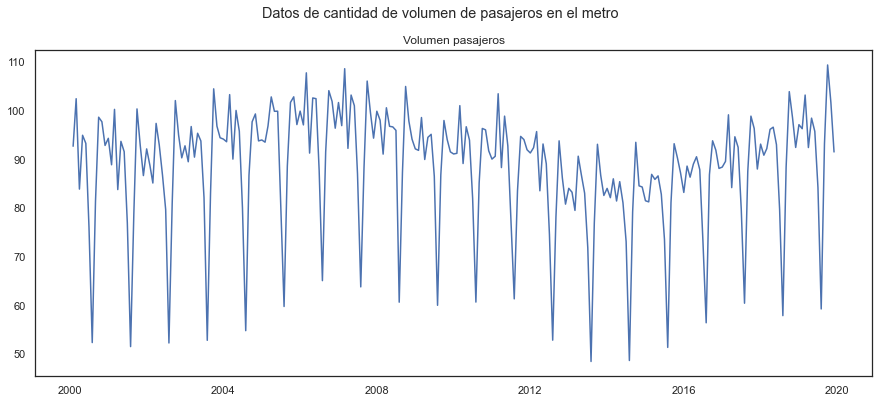

In [19]:
fig, (ax1) = plt.subplots(1,1,figsize=(15,6))
fig.suptitle("Datos de cantidad de volumen de pasajeros en el metro")
ax1.plot(df.volumenMetro)
ax1.set_title('Volumen pasajeros')
fig.show()

Vemos como la serie presenta una cierta periodicidad de los datos, pues la forma que toma la serie es similar en todo el tiempo. Presentando cierta tendencia sinusoidal, si queremos aplicar el modelo ARIMA, debemos "eliminar" esta componente estacional, mediante por ejemplo normalizando podríamos obtener un ruido blanco.

Decimos que un proceso estocástico es un ruido blanco si 

$$ E[X(t)] = 0 \ \ \ \ \ \ \ \ \ \  V[X(t)]=\sigma^2  \ \ \ \ \ \ \ \ \ \ \gamma_k=0 $$

El objetivo es ajustar el modelo ARIMA es que el error producido sea un ruido blanco, esto significará que nuestro modelo está bien ajustado.

Actualmente, vemos con un gráfico de cajas y bigotes y un histográma, que la distribución de nuestra serie no es simétrica y esto se debe a que aunque tenemos una periodicidad de los datos muy clara, existe tendencia, provocando que la distribución de la serie no sea simétrica, con una media distante a la mediana y una desviación tipìca elevada. Por lo que nuestra serie no es estacionaria.

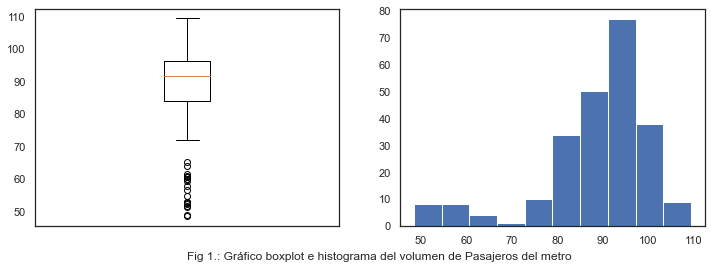

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.boxplot(df['volumenMetro'])
ax1.text(1,35, "Fig 1.: Gráfico boxplot e histograma del volumen de Pasajeros del metro")
ax1.set_xticklabels('')
ax2.hist(df['volumenMetro'])
fig.show()

Decimos que aplicamos una diferenciación de orden k a una serie, cuando teniendo $X_t$ le restamos la observación de $k $ instantes anteriores, es decir,  $ X_{t-k} $.

Vamos a hacer una diferenciación de la serie para ver si conseguimos eliminar la media igual a cero y así poder aplicar un modelo $ARIMA(p,d,q)(P,D,Q)_s$.


In [46]:
volDiff = difference(df.volumenMetro, interval=12)

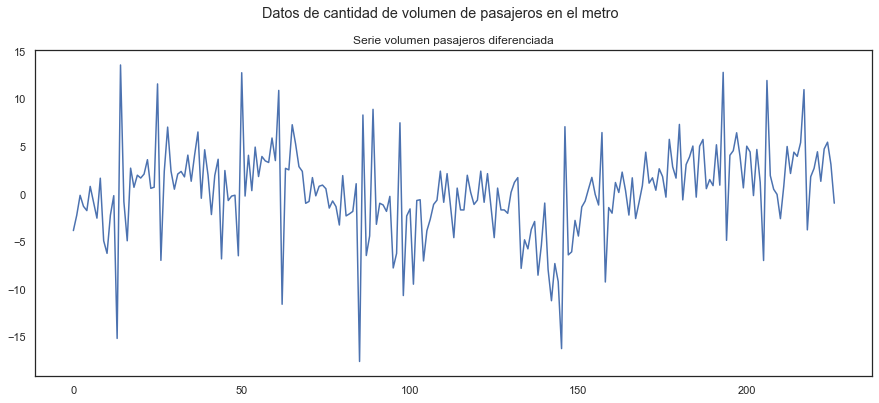

In [47]:
fig, (ax1) = plt.subplots(1,1,figsize=(15,6))
fig.suptitle("Datos de cantidad de volumen de pasajeros en el metro")
ax1.plot(volDiff)
ax1.set_title('Serie volumen pasajeros diferenciada')
fig.show()

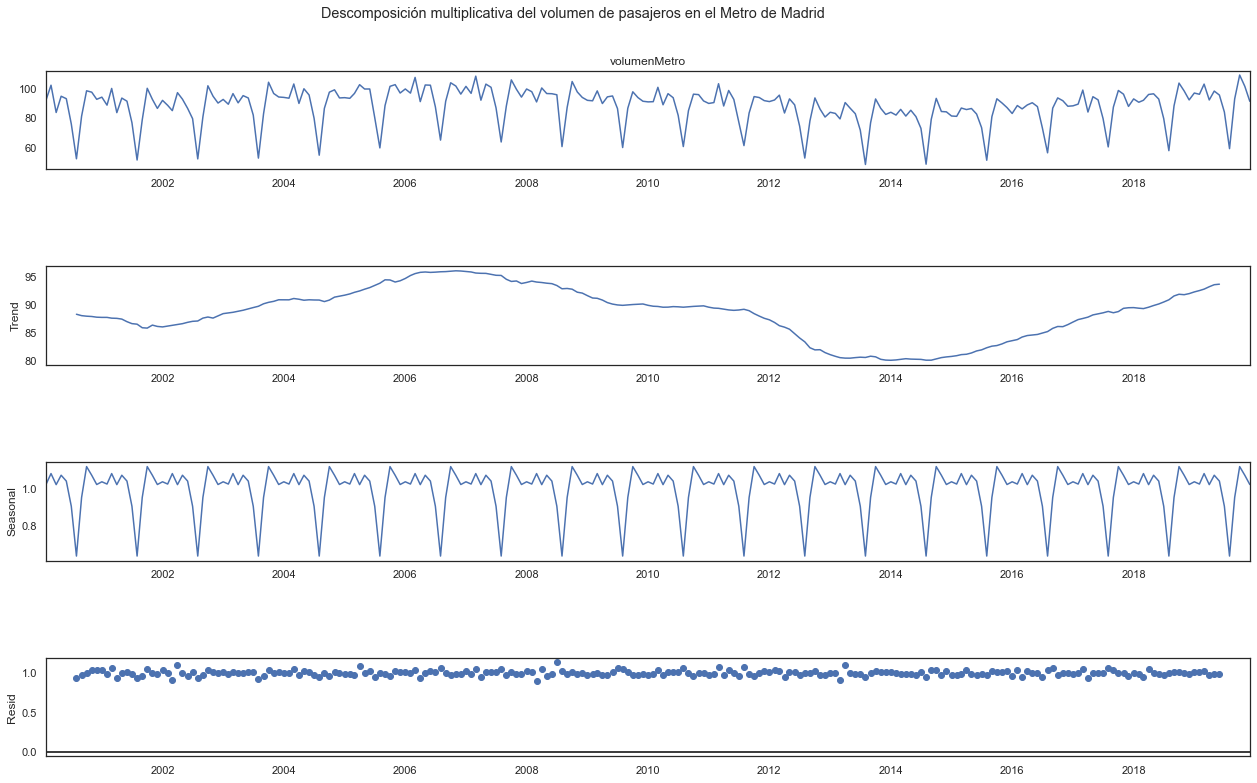

In [12]:
resultV=seasonal_decompose(df['volumenMetro'], model='multiplicable')
fig = resultV.plot()
fig.suptitle('Descomposición multiplicativa del volumen de pasajeros en el Metro de Madrid')
fig.set_size_inches(20, 12)
fig.show()

# Modelo ARIMA  

Destacamos los modelos clásicos:
- Decimos que un modelo es AR(p) (Autoregresivo de orden p), cuando las autocorrelaciones simples decrecen de manera exponencial y existen p autocorrelaciones distintas de $0$.
- Decimos que un modelo es MA(q) (Medias móviles), cuando las autocorrelaciones simples decaen y se cortan de forma rápida, sin embargo las autocorrelaciones parciales decrecen exponencialmente.
- Decimos que un modelo es ARMA(p,q), cuando comparten las características de ambos modelos.

Definimos modelo ARIMA (Autoregresivo integrado de medias móviles), como el modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. Como ya hemos explicado, las series estacionarias son las que tienen media $0$, por lo tanto, un proceso no estacionario lo llamaremos proceso integrado si al hacer una diferenciación se obtienen procesos estacionarios.

# Bibliografía

https://www.ucm.es/data/cont/docs/518-2013-11-11-JAM-IAST-Libro.pdf